In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Let's first compare the two datasets to ensure there is consistency between them and determine what cleaning we need to do.

In [2]:

df= pd.read_csv(r"C:\Users\harshika jain\Documents\NetBeansProjects\timetable\timetable\build\classes\Titanic_Survival_Prediction\data\train.csv")
print(df)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ... 

In [3]:
df= pd.read_csv(r"C:\Users\harshika jain\Documents\NetBeansProjects\timetable\timetable\build\classes\Titanic_Survival_Prediction\data\test.csv")
print(df)

     PassengerId  Pclass                                          Name  \
0            892       3                              Kelly, Mr. James   
1            893       3              Wilkes, Mrs. James (Ellen Needs)   
2            894       2                     Myles, Mr. Thomas Francis   
3            895       3                              Wirz, Mr. Albert   
4            896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)   
..           ...     ...                                           ...   
413         1305       3                            Spector, Mr. Woolf   
414         1306       1                  Oliva y Ocana, Dona. Fermina   
415         1307       3                  Saether, Mr. Simon Sivertsen   
416         1308       3                           Ware, Mr. Frederick   
417         1309       3                      Peter, Master. Michael J   

        Sex   Age  SibSp  Parch              Ticket      Fare Cabin Embarked  
0      male  34.5      0      0 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [5]:
df= pd.read_csv(r"C:\Users\harshika jain\Documents\NetBeansProjects\timetable\timetable\build\classes\Titanic_Survival_Prediction\data\test.csv")
print(df)

     PassengerId  Pclass                                          Name  \
0            892       3                              Kelly, Mr. James   
1            893       3              Wilkes, Mrs. James (Ellen Needs)   
2            894       2                     Myles, Mr. Thomas Francis   
3            895       3                              Wirz, Mr. Albert   
4            896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)   
..           ...     ...                                           ...   
413         1305       3                            Spector, Mr. Woolf   
414         1306       1                  Oliva y Ocana, Dona. Fermina   
415         1307       3                  Saether, Mr. Simon Sivertsen   
416         1308       3                           Ware, Mr. Frederick   
417         1309       3                      Peter, Master. Michael J   

        Sex   Age  SibSp  Parch              Ticket      Fare Cabin Embarked  
0      male  34.5      0      0 

Both datasets are missing well over 10% of the Cabin data, so I will drop this column. For the Age column, this data will likely be important so I want to keep the column. I will fill the missing volues with the mean age based on the Sex of the person. I will fill the missing Embarked values with the mode, and the missing Fare amounts with the mean per corresponding Pclass.

In [6]:
df['Name'].head()

0                                Kelly, Mr. James
1                Wilkes, Mrs. James (Ellen Needs)
2                       Myles, Mr. Thomas Francis
3                                Wirz, Mr. Albert
4    Hirvonen, Mrs. Alexander (Helga E Lindqvist)
Name: Name, dtype: object

In [7]:
def clean_data(df):
    df = df.drop(['Cabin', 'Ticket'], axis=1)
    df['Age'] = df['Age'].fillna(df.groupby('Sex')['Age'].transform('mean'))
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    df['Fare'] = df['Fare'].fillna(df.groupby('Pclass')['Fare'].transform('mean'))
                
    return df

There are a few additional columns I want to make as well. First, the name columns tend to have some titles associated with them which could provide info on the perceived importance or social rank of a person, which could impact their survival rate. I want to extract that title and set it as a new value in the dataframe.

In [8]:
def create_title_column(df):
    df['Title'] = df['Name'].str.split(',').str[1].str.split('.').str[0].str.strip()
    title_counts = df['Title'].value_counts()
    rare_title = title_counts[title_counts < 10].index
    df['Title'] = df['Title'].replace(rare_title, 'Other')
    df = df.drop(['Name'], axis=1)
    
    return df


To make information a little more generalized, I want to bin some information such as age and fare amount. I noticed that certain age ranges have higher survival rates than others, so I want to try and bin these in a way that groups people into a bin with others who have similar survival rates. For fares, I'll bin based on 3 levels of high medium and low.

In [9]:
def create_bins(df):
    bin_range = [0, 5, 10, 15, 30, 40, 50, 60, 70, 80]  
    labels = range(1, len(bin_range))
    df['Age_Bin'] = pd.cut(df['Age'], bins=bin_range, labels=labels).astype(int)
    df['Fare_Bin'] = pd.qcut(df['Fare'], q=3, labels=[1, 2, 3]).astype(int)

    return df

I also want a numerical representation of some of our categorical string variables. I will set those here:

In [10]:
def encode_categorical_variables(df):
    label_encoder = LabelEncoder()
    df['Embarked_Code'] = label_encoder.fit_transform(df['Embarked'])
    df['Sex_Code'] = label_encoder.fit_transform(df['Sex'])
    df['Title_Code'] = label_encoder.fit_transform(df['Title'])
    
    return df


Now let's run our dataframes through these cleaning and pre-processing functions we defined above.

In [11]:
df = df.dropna()
print(df)

     PassengerId  Pclass                                               Name  \
12           904       1      Snyder, Mrs. John Pillsbury (Nelle Stevenson)   
14           906       1  Chaffee, Mrs. Herbert Fuller (Carrie Constance...   
24           916       1    Ryerson, Mrs. Arthur Larned (Emily Maria Borie)   
26           918       1                       Ostby, Miss. Helene Ragnhild   
28           920       1                            Brady, Mr. John Bertram   
..           ...     ...                                                ...   
404         1296       1                       Frauenthal, Mr. Isaac Gerald   
405         1297       2       Nourney, Mr. Alfred (Baron von Drachstedt")"   
407         1299       1                         Widener, Mr. George Dunton   
411         1303       1    Minahan, Mrs. William Edward (Lillian E Thorpe)   
414         1306       1                       Oliva y Ocana, Dona. Fermina   

        Sex   Age  SibSp  Parch         Ticket     

Let's check to make sure the cleaning was done properly on both sets.

In [12]:
df.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,87.000000,87.000000,87,87,87.000000,87.000000,87.000000,87,87.000000,87,87
unique,NaN,NaN,87,2,NaN,NaN,NaN,66,NaN,72,3
top,NaN,NaN,"Snyder, Mrs. John Pillsbury (Nelle Stevenson)",female,NaN,NaN,NaN,113503,NaN,B57 B59 B63 B66,C
freq,NaN,NaN,1,44,NaN,NaN,NaN,4,NaN,3,47
mean,1102.712644,1.137931,NaN,NaN,39.247126,0.597701,0.482759,NaN,98.109198,NaN,NaN
std,126.751901,0.435954,NaN,NaN,15.218730,0.637214,0.860801,NaN,88.177319,NaN,NaN
min,904.000000,1.000000,NaN,NaN,1.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,986.000000,1.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,35.339600,NaN,NaN
50%,1094.000000,1.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,71.283300,NaN,NaN
75%,1216.000000,1.000000,NaN,NaN,50.000000,1.000000,1.000000,NaN,135.066650,NaN,NaN


In [13]:
df.dropna(how='all')
print(df)

     PassengerId  Pclass                                               Name  \
12           904       1      Snyder, Mrs. John Pillsbury (Nelle Stevenson)   
14           906       1  Chaffee, Mrs. Herbert Fuller (Carrie Constance...   
24           916       1    Ryerson, Mrs. Arthur Larned (Emily Maria Borie)   
26           918       1                       Ostby, Miss. Helene Ragnhild   
28           920       1                            Brady, Mr. John Bertram   
..           ...     ...                                                ...   
404         1296       1                       Frauenthal, Mr. Isaac Gerald   
405         1297       2       Nourney, Mr. Alfred (Baron von Drachstedt")"   
407         1299       1                         Widener, Mr. George Dunton   
411         1303       1    Minahan, Mrs. William Edward (Lillian E Thorpe)   
414         1306       1                       Oliva y Ocana, Dona. Fermina   

        Sex   Age  SibSp  Parch         Ticket     

In [14]:
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
12,904,1,"Snyder, Mrs. John Pillsbury (Nelle Stevenson)",female,23.0,1,0,21228,82.2667,B45,S
14,906,1,"Chaffee, Mrs. Herbert Fuller (Carrie Constance...",female,47.0,1,0,W.E.P. 5734,61.1750,E31,S
24,916,1,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",female,48.0,1,3,PC 17608,262.3750,B57 B59 B63 B66,C
26,918,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,B36,C
28,920,1,"Brady, Mr. John Bertram",male,41.0,0,0,113054,30.5000,A21,S


I want to visualize the data distribution of both datasets to check what kind of distribution the data has, but also check to see if both datasets are similar in their distribution.

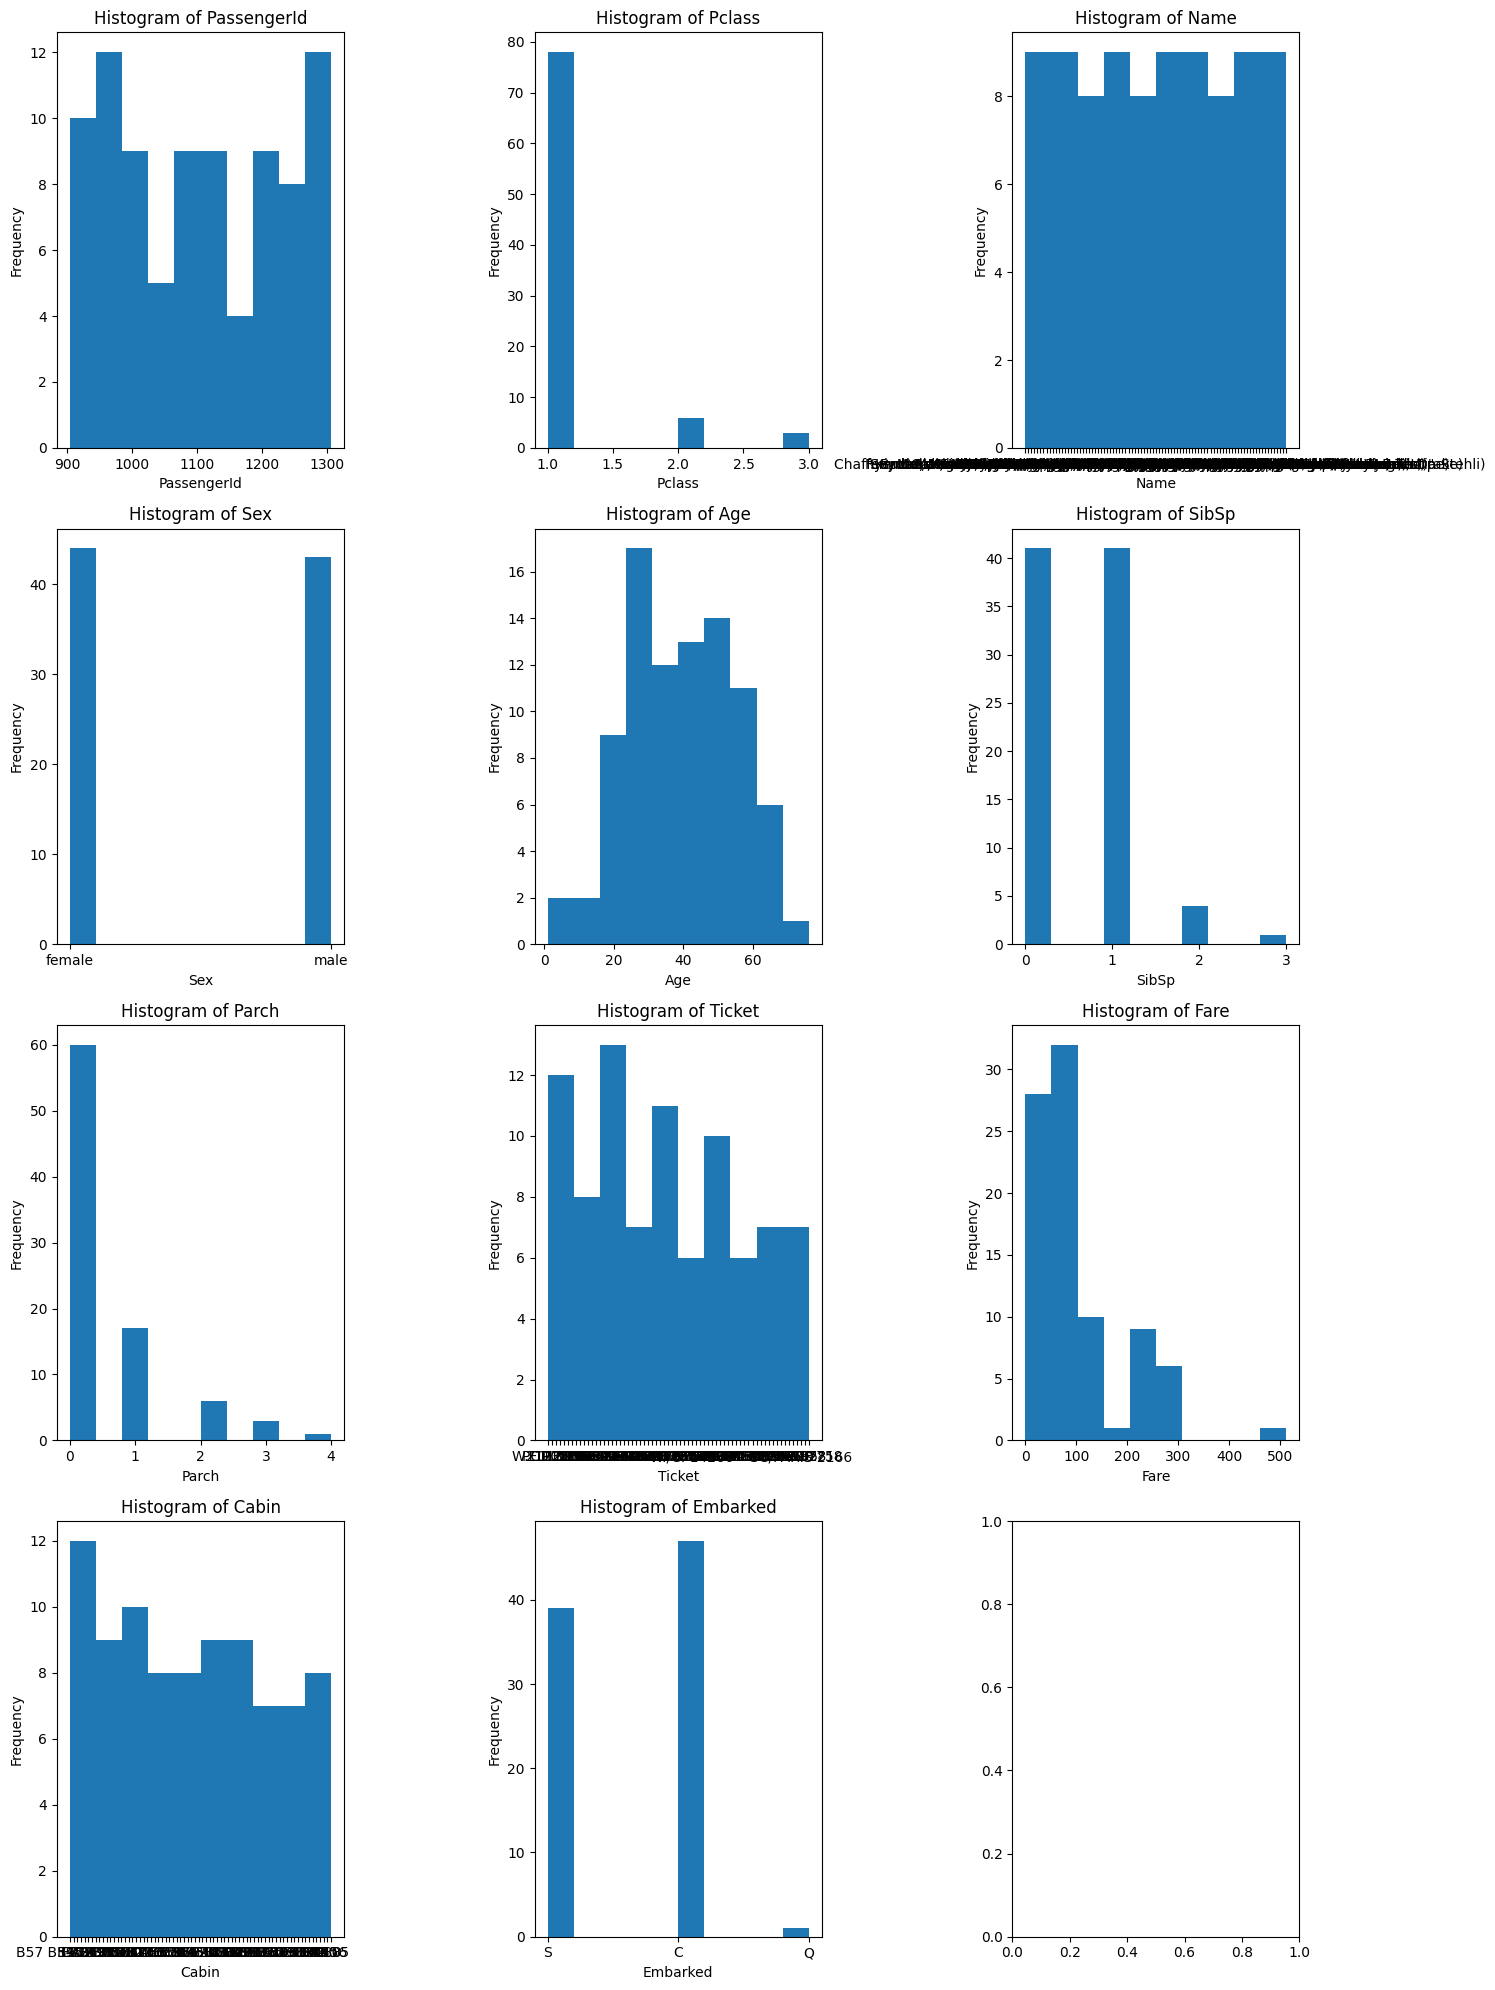

In [15]:
num_plots = len(df.columns)
num_rows = (num_plots + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(df.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    df[column].hist(ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {column}')

plt.tight_layout()
for ax in axes.flatten():
    ax.grid(False)

Now let's see how the information breaks down in terms of survival rates.

Since age seems to be a major defining factor in survival rates, I want to make additional binary columns to distinguish if a passenger was a child or an elder. 

In [16]:
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
12,904,1,"Snyder, Mrs. John Pillsbury (Nelle Stevenson)",female,23.0,1,0,21228,82.2667,B45,S
14,906,1,"Chaffee, Mrs. Herbert Fuller (Carrie Constance...",female,47.0,1,0,W.E.P. 5734,61.1750,E31,S
24,916,1,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",female,48.0,1,3,PC 17608,262.3750,B57 B59 B63 B66,C
26,918,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,B36,C
28,920,1,"Brady, Mr. John Bertram",male,41.0,0,0,113054,30.5000,A21,S


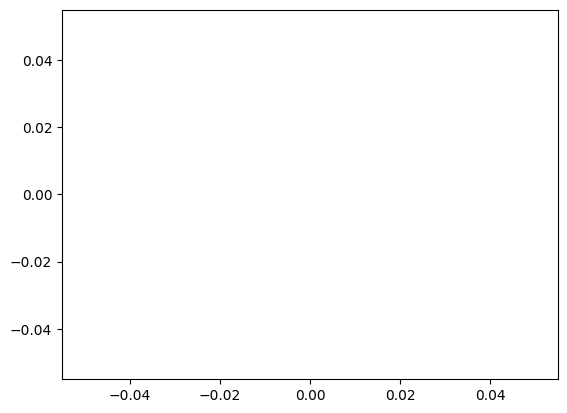

In [17]:
sns.histplot()
plt.show()

We can see that survival rate appears to be much lower for those labeled as Elder's and much higher for those labeled as children. Let's use some pie charts to do some more survival rate comparisons.

In [18]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

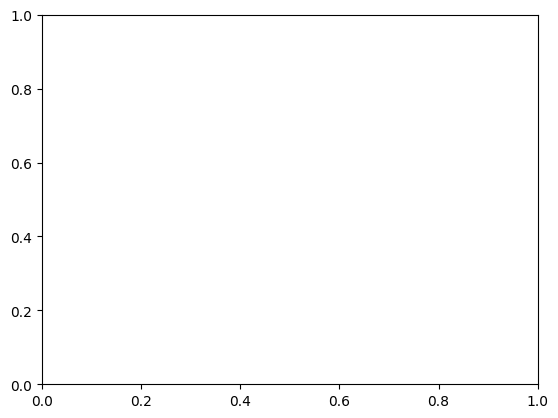

In [19]:
plt.tick_params()
plt.show()

In [20]:
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [21]:
plt.tight_layout()
for ax in axes.flatten():
    ax.grid(False)

<Figure size 640x480 with 0 Axes>

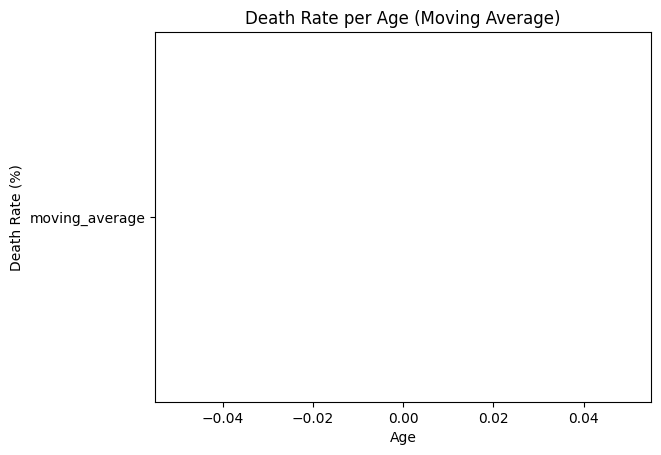

In [22]:

plt.plot('moving_average')
plt.xlabel('Age')
plt.ylabel('Death Rate (%)')
plt.title('Death Rate per Age (Moving Average)')
plt.show()

<Axes: >

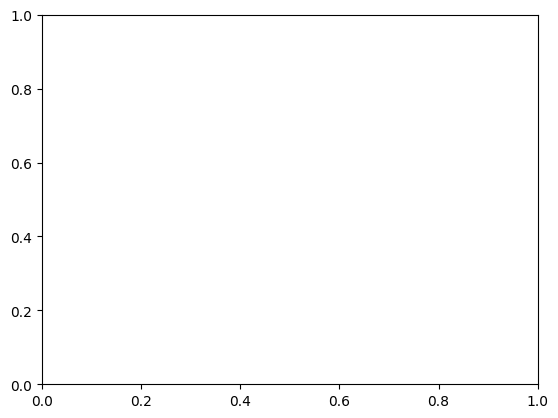

In [23]:
sns.barplot()

We can see that elements such as Sex, Class, Title, Age, and Parch all have impacts on survival rate. I want to explore if the size of someones guest list can be exploited further to find more insights. I'll make a column called Family size, and then corresponding Alone & Big Family binary columns to see if that provides more information.

In [24]:
df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

So we now have a good idea of the variations in survival rate based on various passenger attributes. What I want to do now is quantify that survival change as some sort of score. I'll make a new dataframe that is based on the survival rate of various columns to see if I can give people a score based on how many high risk/medium risk or low risk attributes they have.

In [25]:
df_survival_rate = df.copy()

In [26]:
df_survival_rate.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
12,904,1,"Snyder, Mrs. John Pillsbury (Nelle Stevenson)",female,23.0,1,0,21228,82.2667,B45,S
14,906,1,"Chaffee, Mrs. Herbert Fuller (Carrie Constance...",female,47.0,1,0,W.E.P. 5734,61.1750,E31,S
24,916,1,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",female,48.0,1,3,PC 17608,262.3750,B57 B59 B63 B66,C
26,918,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,B36,C
28,920,1,"Brady, Mr. John Bertram",male,41.0,0,0,113054,30.5000,A21,S


Great, so we now have 4 survival levels for some key columns (1 for low survival rate, 4 for high). Let's use this info to decide how to add some survival scores to our main dataframe.

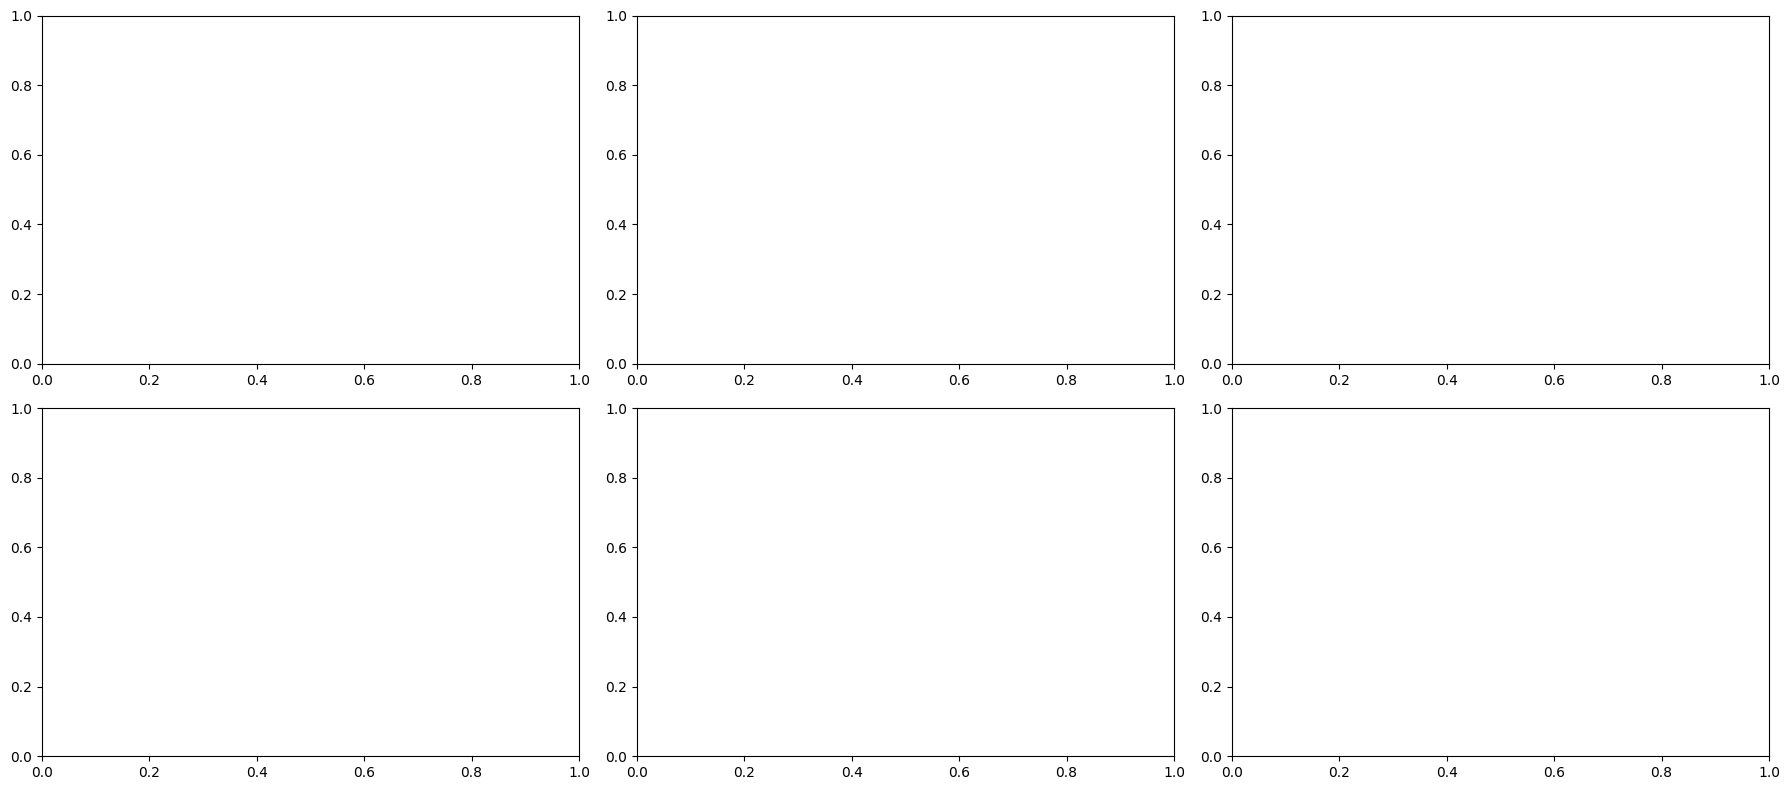

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
plt.tight_layout()



Based on these visuals, I can apply a score to different values in those columns. For instance, someone in first class can have a 3 survival score since they are most likely to survive amongst that variable. I'll aim for 3 levels per variable, however for extreme discrepencies, I may keep all 4 survival levels for certain columns.

Mapping the column values to their respective survival level.

In [28]:
def add_survival_levels(df):
    df['Survival_Level_Pclass'] = df['Pclass'].map({1: 3, 2: 2, 3: 1}).astype(int)
    df['Survival_Level_Sex'] = df['Sex'].map({'male': 1, 'female': 3}).astype(int)
    df['Survival_Level_Title'] = df['Title'].map({'Mr': 1, 'Mrs': 4, 'Miss': 4, 'Master': 3, 'Other': 2}).astype(int)
    df['Survival_Level_Age_Bin'] = df['Age_Bin'].map({1: 4, 2: 2, 3: 4, 4: 2, 5: 1, 6: 2, 7: 2, 8: 1, 9: 1}).astype(int)
    df['Survival_Level_Fare_Bin'] = df['Fare_Bin'].map({1: 1, 2: 2, 3: 3}).astype(int)
    df['Survival_Level_Embarked'] = df['Embarked'].map({'S': 1, 'C': 3, 'Q': 1}).astype(int)
    df['Survival_Level_Family'] = df['Family_Category'].map({'Medium': 3, 'Large': 3, 'Alone': 2, 'Small': 1}).astype(int)

    df['Survival_Level_Sum'] = df[['Survival_Level_Pclass', 'Survival_Level_Sex', 'Survival_Level_Title', 'Survival_Level_Age_Bin', 'Survival_Level_Fare_Bin', 'Survival_Level_Embarked', 'Survival_Level_Family']].sum(axis=1)
    return df


Drop the uneeded extra columns.

In [29]:
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
12,904,1,"Snyder, Mrs. John Pillsbury (Nelle Stevenson)",female,23.0,1,0,21228,82.2667,B45,S
14,906,1,"Chaffee, Mrs. Herbert Fuller (Carrie Constance...",female,47.0,1,0,W.E.P. 5734,61.1750,E31,S
24,916,1,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",female,48.0,1,3,PC 17608,262.3750,B57 B59 B63 B66,C
26,918,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,B36,C
28,920,1,"Brady, Mr. John Bertram",male,41.0,0,0,113054,30.5000,A21,S


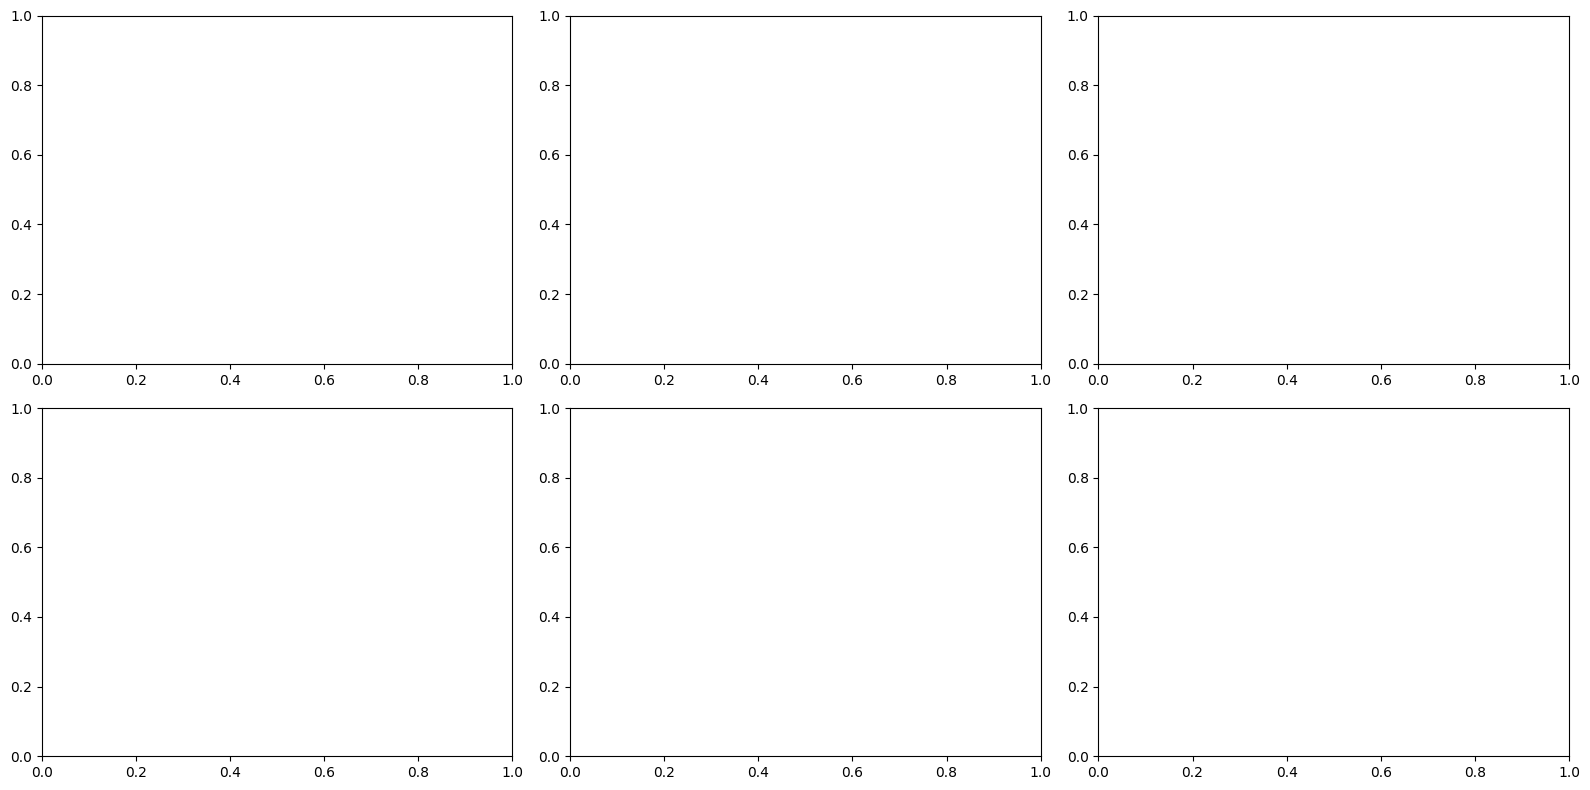

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
plt.tight_layout()


Let's see if we can bin the survival level sum to a smaller number of categories to better generalize the data. Let's review the survival rates per level to see what binning makes the most sense.

Now let's review what the correlation is between our variables and survival to start determining which columns to use in our models.

In [31]:
plt.show()

I'm also going to check the feature importance using a decision tree model to further review the impact features have on the Survival outcome prediction.

I'll mainly try a different variation of these features to see which has the best results with the models.

In [32]:
cat_columns = ['Survival_Chance', 'Sex_Code', 'Pclass', 'Age_Bin', 'Title_Code', 'Family_Category', 'Fare_Bin', 'Embarked_Code', 'Alone', 'Child', 'Elder']
num_columns = ['Age*Class*Sex']
target = 'Survived'

**Linear Model: Logistic Regression**

In [33]:
param_grid = {'C': [0.1, 1, 10, 100], 'max_iter': [5000, 10000]}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train_temp)

best_params = grid_search.best_params_
print("Best parameters found:", best_params)
print("\n")


best_logistic_model = grid_search.best_estimator_

logistic_predict_test = best_logistic_model.predict(X_test_transformed)
logistic_accuracy_score_test = accuracy_score(y_test, logistic_predict_test)
logistic_f1_score_test = f1_score(y_test, logistic_predict_test)
logistic_auc_score_test = roc_auc_score(y_test, logistic_predict_test)

logistic_predict_valid = best_logistic_model.predict(X_valid_transformed)
logistic_accuracy_score_valid = accuracy_score(y_valid, logistic_predict_valid)
logistic_f1_score_valid = f1_score(y_valid, logistic_predict_valid)
logistic_auc_score_valid = roc_auc_score(y_valid, logistic_predict_valid)

logistic_report_test = classification_report(y_test, logistic_predict_test)
logistic_report_valid = classification_report(y_valid, logistic_predict_valid)

print("Classification Report - Test Data:")
print(logistic_report_test)

print("Classification Report - Validation Data:")
print(logistic_report_valid)

NameError: name 'GridSearchCV' is not defined

**Non-Linear Model: Decision Tree**

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],'max_depth': [3, 5, 7, None],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}

decision_tree = DecisionTreeClassifier()

grid_search = GridSearchCV(decision_tree, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train_temp)

best_params = grid_search.best_params_
print("Best parameters found:", best_params)
print("\n")

best_dt_model = DecisionTreeClassifier(**best_params)

best_dt_model.fit(X_train_transformed, y_train_temp)

dt_predictions = best_dt_model.predict(X_test_transformed)
dt_accuracy_score_test = metrics.accuracy_score(y_test, dt_predictions)
dt_f1_score_test = f1_score(y_test, dt_predictions)
dt_auc_score_test = roc_auc_score(y_test, dt_predictions)

dt_predictions_valid = best_dt_model.predict(X_valid_transformed)
dt_accuracy_score_valid =  metrics.accuracy_score(y_valid, dt_predictions_valid)
dt_f1_score_valid = f1_score(y_valid, dt_predictions_valid)
dt_auc_score_valid = roc_auc_score(y_valid, dt_predictions_valid)

dt_report_test = classification_report(y_test, dt_predictions)
dt_report_valid = classification_report(y_valid, dt_predictions_valid)

print("Classification Report - Test Data:")
print(dt_report_test)

print("Classification Report - Validation Data:")
print(dt_report_valid)



Best parameters found: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85        70
           1       0.84      0.81      0.83        64

    accuracy                           0.84       134
   macro avg       0.84      0.83      0.84       134
weighted avg       0.84      0.84      0.84       134

Classification Report - Validation Data:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        87
           1       0.72      0.72      0.72        47

    accuracy                           0.81       134
   macro avg       0.79      0.79      0.79       134
weighted avg       0.81      0.81      0.81       134



**Non-Linear Model: Random Forest**

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],'max_depth': [3, 5, 7, None],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4, 8],'n_estimators': [10, 50, 100, 200]}

rf_model = RandomForestClassifier()

grid_search = GridSearchCV(rf_model, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train_temp)

best_params = grid_search.best_params_
print("Best parameters found:", best_params)
print("\n")


best_rf_model = grid_search.best_estimator_ 

rf_predictions_test = best_rf_model.predict(X_test_transformed)
rf_accuracy_score_test = accuracy_score(y_test, rf_predictions_test)
rf_f1_score_test = f1_score(y_test, rf_predictions_test)
rf_auc_score_test = roc_auc_score(y_test, rf_predictions_test)

rf_predictions_valid = best_rf_model.predict(X_valid_transformed)
rf_accuracy_score_valid = accuracy_score(y_valid, rf_predictions_valid)
rf_f1_score_valid = f1_score(y_valid, rf_predictions_valid)
rf_auc_score_valid = roc_auc_score(y_valid, rf_predictions_valid)

rf_report_test = classification_report(y_test, rf_predictions_test)
rf_report_valid = classification_report(y_valid, rf_predictions_valid)

print("Classification Report - Test Data:")
print(rf_report_test)

print("Classification Report - Validation Data:")
print(rf_report_valid)

Best parameters found: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        70
           1       0.89      0.75      0.81        64

    accuracy                           0.84       134
   macro avg       0.84      0.83      0.83       134
weighted avg       0.84      0.84      0.83       134

Classification Report - Validation Data:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        87
           1       0.79      0.66      0.72        47

    accuracy                           0.82       134
   macro avg       0.81      0.78      0.79       134
weighted avg       0.82      0.82      0.82       134



**Boosting Model: XGBoost**

In [ ]:
param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.01, 0.001]}

xgb_model = xgb.XGBClassifier()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train_temp)


best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print("\n")

best_xgb_model = grid_search.best_estimator_

xgb_predict_test = best_xgb_model.predict(X_test_transformed)
xgb_accuracy_score_test = metrics.accuracy_score(y_test, xgb_predict_test)
xgb_f1_score_test = f1_score(y_test, xgb_predict_test)
xgb_auc_score_test = roc_auc_score(y_test, xgb_predict_test)

xgb_predict_valid = best_xgb_model.predict(X_valid_transformed)
xgb_accuracy_score_valid =  metrics.accuracy_score(y_valid, xgb_predict_valid)
xgb_f1_score_valid = f1_score(y_valid, xgb_predict_valid)
xgb_auc_score_valid = roc_auc_score(y_valid, xgb_predict_valid)

xgb_report_test = classification_report(y_test, xgb_predict_test)
xgb_report_valid = classification_report(y_valid, xgb_predict_valid)

print("Classification Report - Test Data:")
print(xgb_report_test)

print("Classification Report - Validation Data:")
print(xgb_report_valid)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        70
           1       0.87      0.73      0.80        64

    accuracy                           0.82       134
   macro avg       0.83      0.82      0.82       134
weighted avg       0.83      0.82      0.82       134

Classification Report - Validation Data:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86        87
           1       0.78      0.66      0.71        47

    accuracy                           0.81       134
   macro avg       0.80      0.78      0.79       134
weighted avg       0.81      0.81      0.81       134



In [ ]:
print("Data description")
print("----------------")
print("Number of examples")
print(f"train: {len(X_train_temp)}")
print(f"valid: {len(X_valid)}")
print(f"test: {len(X_test)}")
print("\n")
print(f"Number of features: {X_train_temp.shape[1]}")

print("\nNumber of examples per class")
print(f"class 0 - train: {sum(y_train_temp == 0)}")
print(f"class 1 - train: {sum(y_train_temp == 1)}")
print("\n")
print(f"class 0 - valid: {sum(y_valid == 0)}")
print(f"class 1 - valid: {sum(y_valid == 1)}")
print("\n")
print(f"class 0 - test: {sum(y_test == 0)}")
print(f"class 1 - test: {sum(y_test == 1)}")

Data description
----------------
Number of examples
train: 623
valid: 134
test: 134


Number of features: 12

Number of examples per class
class 0 - train: 392
class 1 - train: 231


class 0 - valid: 87
class 1 - valid: 47


class 0 - test: 70
class 1 - test: 64


In [ ]:
print("\nDescriptive statistics")
print("----------------------")
print("\n")

train_stats = X_train_temp.describe().transpose()
valid_stats = X_valid.describe().transpose()
test_stats = X_test.describe().transpose()

for dataset_name, dataset_stats in zip(['Training', 'Validation', 'Test'], [train_stats, valid_stats, test_stats]):
    print(f"{dataset_name} dataset:")
    print("-----------------")
    for column_name, stats in dataset_stats.iterrows():
        print(column_name)
        print(f"  Mean: {stats['mean']}, Median: {stats['50%']}, Standard Deviation: {stats['std']}")
    print("\n")


Descriptive statistics
----------------------


Training dataset:
-----------------
Survival_Chance
  Mean: 1.8812199036918138, Median: 2.0, Standard Deviation: 0.9993649694880555
Sex_Code
  Mean: 0.6581059390048154, Median: 1.0, Standard Deviation: 0.4747254495226463
Pclass
  Mean: 2.3418940609951844, Median: 3.0, Standard Deviation: 0.81994487012546
Age_Bin
  Mean: 4.497592295345104, Median: 4.0, Standard Deviation: 1.3725292847033157
Title_Code
  Mean: 1.8860353130016052, Median: 2.0, Standard Deviation: 0.7927611675955439
Fare_Bin
  Mean: 1.9775280898876404, Median: 2.0, Standard Deviation: 0.8174989240171361
Embarked_Code
  Mean: 1.5585874799357946, Median: 2.0, Standard Deviation: 0.7750236558803775
Alone
  Mean: 0.5971107544141252, Median: 1.0, Standard Deviation: 0.490872966320433
Child
  Mean: 0.10272873194221509, Median: 0.0, Standard Deviation: 0.303848205131399
Elder
  Mean: 0.016051364365971106, Median: 0.0, Standard Deviation: 0.12577404302022416
Age*Class*Sex
  Mean: 11

In [ ]:
print("\nModel Validation Results")
print("\n")

print("Model 1: Logistic Regression")
print("----------------------------------")
print("Accuracy - Validation:", logistic_accuracy_score_valid)
print("F1 Score - Validation:", logistic_f1_score_valid)
print("AUC Score - Validation:", logistic_auc_score_valid)
print("\n")

print("Model 2: Decision Tree Classifier")
print("----------------------------------")
print("Accuracy - Validation:", dt_accuracy_score_valid)
print("F1 Score - Validation:", dt_f1_score_valid)
print("AUC Score - Validation:", dt_auc_score_valid)
print("\n")

print("Model 3: Random Forest Classifier")
print("----------------------------------")
print("Accuracy - Validation:", rf_accuracy_score_valid)
print("F1 Score - Validation:", rf_f1_score_valid)
print("AUC Score - Validation:", rf_auc_score_valid)
print("\n")


print("Model 4: XGB Classifier")
print("----------------------------------")
print("Accuracy - Validation:", xgb_accuracy_score_valid)
print("F1 Score - Validation:", xgb_f1_score_valid)
print("AUC Score - Validation:", xgb_auc_score_valid)



Model Validation Results


Model 1: Logistic Regression
----------------------------------
Accuracy - Validation: 0.8208955223880597
F1 Score - Validation: 0.7272727272727273
AUC Score - Validation: 0.7887013939838592


Model 2: Decision Tree Classifier
----------------------------------
Accuracy - Validation: 0.8059701492537313
F1 Score - Validation: 0.723404255319149
AUC Score - Validation: 0.7869894839814136


Model 3: Random Forest Classifier
----------------------------------
Accuracy - Validation: 0.8208955223880597
F1 Score - Validation: 0.7209302325581396
AUC Score - Validation: 0.7838102225483004


Model 4: XGB Classifier
----------------------------------
Accuracy - Validation: 0.8134328358208955
F1 Score - Validation: 0.7126436781609196
AUC Score - Validation: 0.7780630961115187


I want to check the prediction results on the separate test dataset file to see if the results are similar to what we see previously.

In [ ]:
df_test_transformed = preprocessor.transform(df_test[cat_columns + num_columns])

In [ ]:
df_test.head()

,PassengerId,Pclass,Sex,Age,Parch,Fare,Age_Bin,Fare_Bin,Embarked_Code,Sex_Code,...,Elder,Age*Class*Sex,Fam_Size,Alone,Family_Category,Survival_Chance,Logistic Prediction,DT Prediction,RF Prediction,XGB Prediction
0,892,3,male,34.5,0,7.8292,5,1,1,1,...,0,207.0,1,1,Small,1,0,0,0,0
1,893,3,female,47.0,0,7.0000,6,1,2,0,...,0,141.0,2,0,Small,4,1,1,0,0
2,894,2,male,62.0,0,9.6875,8,2,1,1,...,1,248.0,1,1,Alone,2,0,0,0,0
3,895,3,male,27.0,0,8.6625,4,1,2,1,...,0,162.0,1,1,Small,3,0,0,0,0
4,896,3,female,22.0,1,12.2875,4,2,2,0,...,0,66.0,3,0,Alone,1,0,1,0,1
